# Imports

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# Load Data

In [5]:
from helper_functions import subject_df

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/helper_functions.py:23: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


In [6]:
import warnings

warnings.filterwarnings('ignore')

# Function to load all participants
df_good = pd.read_csv('../02_analysis/df_good.csv')

df = subject_df(df=df_good, sub_num=0)

In [4]:
# # Training Data
# X = pd.read_csv('X.csv')

# # Features
# ys = pd.read_csv('ys.csv')

# df = pd.concat([ys, X], axis=1)

# # Make day sequential ints
# df['day'] = range(1, len(df)+1)

In [42]:
df.shape

(85, 2750)

# All Columns

In [43]:
df_split = df.copy()

In [44]:
df_split.shape

(85, 2750)

## Create Categories

In [45]:
# Use pd.cut to create categories
df_split['y_cat'], bins = pd.qcut(df_split['sr_gap_heuristic'], q=2, labels=['Low', 'High'], retbins=True)
print(df_split['y_cat'].cat.categories)

print(df_split['y_cat'])

# # Map categories to boolean
# df_split['y_high_gap'] = df_split['y_high_gap'].map({'Low': False, 'High': True})

Index(['Low', 'High'], dtype='object')
0      Low
1     High
2     High
3     High
4     High
      ... 
80     Low
81    High
82    High
83    High
84     NaN
Name: y_cat, Length: 85, dtype: category
Categories (2, object): ['Low' < 'High']


In [46]:
# Make boolean
df_split['y_cat_high'] = df_split['y_cat'].cat.codes
# Replacing -1 with NaN
df_split['y_cat_high'] = df_split['y_cat_high'].replace(-1, np.nan)

# Target column is next days gap
df_split['y_cat_highNextDay'] = df_split['y_cat_high'].shift(-1)

print(df_split['y_cat_high'])

0     0.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
80    0.0
81    1.0
82    1.0
83    1.0
84    NaN
Name: y_cat_high, Length: 85, dtype: float64


In [47]:
df_split['y_cat_high'].value_counts()

y_cat_high
0.0    42
1.0    42
Name: count, dtype: int64

In [48]:
bins

array([0.        , 0.21727173, 1.        ])

### View Gap Category

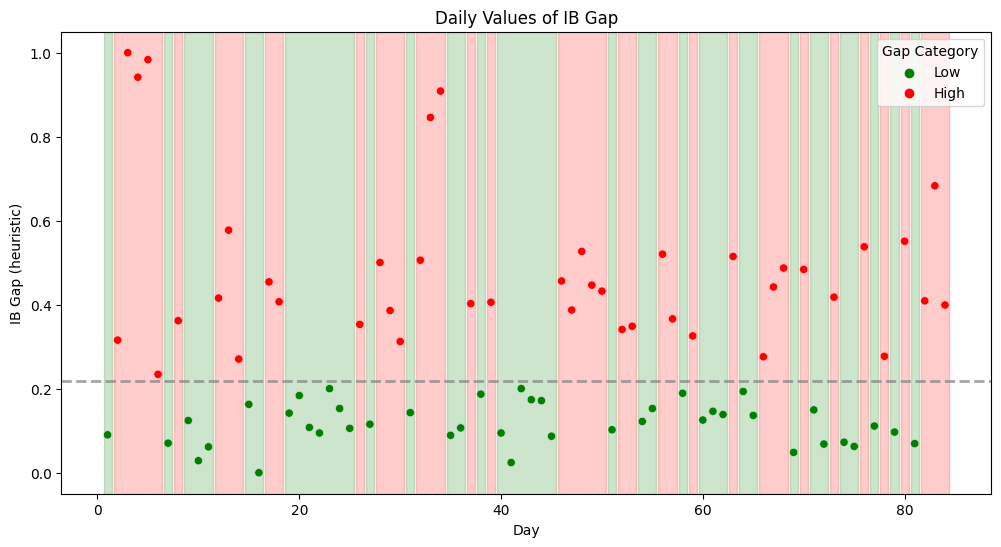

In [21]:
import seaborn as sns

# Map colors to 'y_cat' categories
color_map = {'High': 'red', 'Low': 'green'}

# Create a scatter plot
# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=df_split, x='day', y='sr_gap_heuristic', hue='y_cat', palette=color_map)

# Horizontal Line
ax.axhline(bins[1], color='grey', lw=2, linestyle='--', alpha=0.7)

# Add x-vals for background viz
xs = [] 
ys = []
split_val = .4
for day in df_split['day']:
       
    yval = list(df_split.loc[df_split['day'] == day, 'sr_gap_heuristic'])[0]
       
    xs.append(day-split_val)
    ys.append(yval)
    xs.append(day)
    ys.append(yval)
    xs.append(day + split_val)
    ys.append(yval)

# Background color
ax.fill_between(xs, 0, 1, where=ys < bins[1],
                color='green', alpha=0.2, transform=ax.get_xaxis_transform())

ax.fill_between(xs, 0, 1, where=ys > bins[1],
                color='red', alpha=0.2, transform=ax.get_xaxis_transform())

# Enhance the plot
plt.title('Daily Values of IB Gap')
plt.xlabel('Day')
plt.ylabel('IB Gap (heuristic)')
plt.legend(title='Gap Category')
plt.grid(False)

# Show plot
plt.show()

## Gradient Boosting

In [50]:
df_split = subject_df(df=df_good, sub_num=0)


# Use pd.cut to create categories
df_split['y_cat'], bins = pd.qcut(df_split['sr_gap_heuristic'], q=2, labels=['Low', 'High'], retbins=True)

# Make boolean
df_split['y_cat_high'] = df_split['y_cat'].cat.codes
# Replacing -1 with NaN
df_split['y_cat_high'] = df_split['y_cat_high'].replace(-1, np.nan)

# Target column is next days gap
df_split['y_cat_highNextDay'] = df_split['y_cat_high'].shift(-1)

# Drop non-boolean cat
df_split.drop(columns='y_cat', inplace=True)

# # need to drop tailing rows since no y1 value
# df_split.y_cat_highNextDay.tail()

df_split = df_split.copy()
df_split = df_split.iloc[:-2]

### Predict Median Split Cateogry

In [233]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from scipy.stats import binom_test

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['subject', 'logistic_reg', 'random_forest', 'xgboost', 'ensemble', 'p_val', 'ffill'])

# How many features to use
num_features = 12

for i in range(len(np.unique(df_good.PID))):
    print("Subject", i)
    
    try:
        df_split = subject_df(df=df_good, sub_num=i)

        # Use pd.cut to create categories
        df_split['y_cat'], bins = pd.qcut(df_split['sr_gap_heuristic'], q=2, labels=['Low', 'High'], retbins=True)

        # Make boolean
        df_split['y_cat_high'] = df_split['y_cat'].cat.codes
        # Replacing -1 with NaN
        df_split['y_cat_high'] = df_split['y_cat_high'].replace(-1, np.nan)

        # Target column is next days gap
        df_split['y_cat_highNextDay'] = df_split['y_cat_high'].shift(-1)

        # Drop non-boolean cat
        df_split.drop(columns='y_cat', inplace=True)

        # # need to drop tailing rows since no y1 value
        # df_split.y_cat_highNextDay.tail()

        df_split = df_split.copy()
        df_split = df_split.iloc[:-2]
        
        # Separate features and target variable
        X = df_split.drop(columns=['y_cat_highNextDay'])
        y = df_split['y_cat_highNextDay']

        # Remove initial rows with NaN values for y_cat_high
        while y.isnull().iloc[0]:
            X = X.iloc[1:].reset_index(drop=True)
            y = y.iloc[1:].reset_index(drop=True)
        
        # Count missing values before imputation
        missing_values_before = y.isnull().sum()

        # Impute missing values in the target variable using forward fill
        y = y.fillna(method='ffill')

        # Count missing values after imputation
        missing_values_after = y.isnull().sum()

        # Calculate the number of imputed values
        imputed_value_count = missing_values_before - missing_values_after

        # Ensure there are no more NaN values in y
        if y.isnull().sum() == 0:
            # Handle missing values and standardize features
            imputer = SimpleImputer(strategy='mean')
            scaler = StandardScaler()

            # Feature selection
            k_best = SelectKBest(score_func=f_classif, k=num_features)

            # Models
            log_reg = LogisticRegression(max_iter=1000)
            rf = RandomForestClassifier(n_estimators=100)
            xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')

            # TimeSeriesSplit
            tscv = TimeSeriesSplit(n_splits=5)

            # Pipelines
            log_reg_pipeline = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler),
                ('k_best', k_best),
                ('classifier', log_reg)
            ])

            rf_pipeline = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler),
                ('k_best', k_best),
                ('classifier', rf)
            ])

            xgb_pipeline = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler),
                ('k_best', k_best),
                ('classifier', xgb_clf)
            ])

            # Define the parameter grids for each model
            param_grid_log_reg = {
                'classifier__C': [0.01, 0.1, 1, 10, 100]
            }

            param_grid_rf = {
                'classifier__n_estimators': [50, 100, 200],
                'classifier__max_depth': [None, 10, 20, 30]
            }
            
            # Could add additional hyperparameters for RF
            # Parameter grid for tuning
            # param_grid = {
            #     'n_estimators': [100, 200, 300],
            #     'max_depth': [None, 10, 20, 30],
            #     'min_samples_split': [2, 5, 10],
            #     'min_samples_leaf': [1, 2, 4],
            #     'max_features': ['auto', 'sqrt', 'log2']
            # }

            param_grid_xgb = {
                'classifier__n_estimators': [50, 100, 200],
                'classifier__learning_rate': [0.01, 0.1, 0.2],
                'classifier__max_depth': [3, 6, 9],
                # 'classifier__reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
                # 'classifier__reg_lambda': [0, 0.5, 1, 2]    # L2 regularization
                'classifier__reg_alpha': [0, 0.1, 0.5],  # L1 regularization
                'classifier__reg_lambda': [0, 0.5, 1]    # L2 regularization
            }

            # Setup GridSearchCV for each model
            grid_log_reg = GridSearchCV(log_reg_pipeline, param_grid_log_reg, cv=tscv, scoring='accuracy')
            grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=tscv, scoring='accuracy')
            grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=tscv, scoring='accuracy')

            # Fit the models
            grid_log_reg.fit(X, y)
            grid_rf.fit(X, y)
            grid_xgb.fit(X, y)

            # Print best parameters for the XGBoost model
            print("Best parameters for XGBoost:", grid_xgb.best_params_)

            # Best estimators
            best_log_reg = grid_log_reg.best_estimator_
            best_rf = grid_rf.best_estimator_
            best_xgb = grid_xgb.best_estimator_

            # Ensemble with VotingClassifier
            voting_clf = VotingClassifier(estimators=[
                ('log_reg', best_log_reg),
                ('rf', best_rf),
                ('gb', best_xgb)
            ], voting='soft')

            # Cross-validation for ensemble model
            ensemble_scores = cross_val_score(voting_clf, X, y, cv=tscv, scoring='accuracy')

            # The average performance of the best models across the cross-validation folds
            results = {
                'Logistic Regression': grid_log_reg.best_score_,
                'Random Forest': grid_rf.best_score_,
                'XGBoost': grid_xgb.best_score_,
                'Ensemble': ensemble_scores.mean()
            }
            
            # Number of test samples
            n = len(X)
            # Number of correct predictions (assuming ensemble model predictions)
            k = int(ensemble_scores.mean() * n)
            p_chance = 0.5  # Chance level accuracy
            
            # Perform the binomial test
            p_value = binom_test(k, n, p_chance, alternative='greater')
            
            # Feature importance list
            selector = best_xgb.named_steps['k_best']
            xgb_model = best_xgb.named_steps['classifier']

            mask = selector.get_support()  # Boolean mask
            # or
            selected_indices = selector.get_support(indices=True)  # Indices of selected features
            selected_feature_names = X.columns[selected_indices]

            importances = xgb_model.feature_importances_

            feature_importances = sorted(zip(selected_feature_names, importances), key=lambda x: x[1], reverse=True)
            feature_dict = {feature: importance for feature, importance in feature_importances}
            
            # Save results to the DataFrame using pd.concat
            new_row = pd.DataFrame({
                'subject': [i],
                'logistic_reg': [grid_log_reg.best_score_],
                'random_forest': [grid_rf.best_score_],
                'xgboost': [grid_xgb.best_score_],
                'ensemble': [ensemble_scores.mean()],
                'p_val': [p_value],
                'ffill': [imputed_value_count],
                'feature_import_xgb': [feature_dict]
            })
            results_df = pd.concat([results_df, new_row], ignore_index=True)
            
        else:
            print(f"Skipping subject {i} because the target variable y still contains NaN values after imputation.")
            continue
    except KeyError as err:
        print(f'Error with subject {i} in subject_df() function...')

Subject 0
Best parameters for XGBoost: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 0}
Subject 1
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1}
Subject 2
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 0.5}
Subject 3
Best parameters for XGBoost: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 50, 'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 1}
Subject 4
Best parameters for XGBoost: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 0}
Subject 5
Best parameters fo

In [251]:
feature_imps = results_df.feature_import_xgb[6]

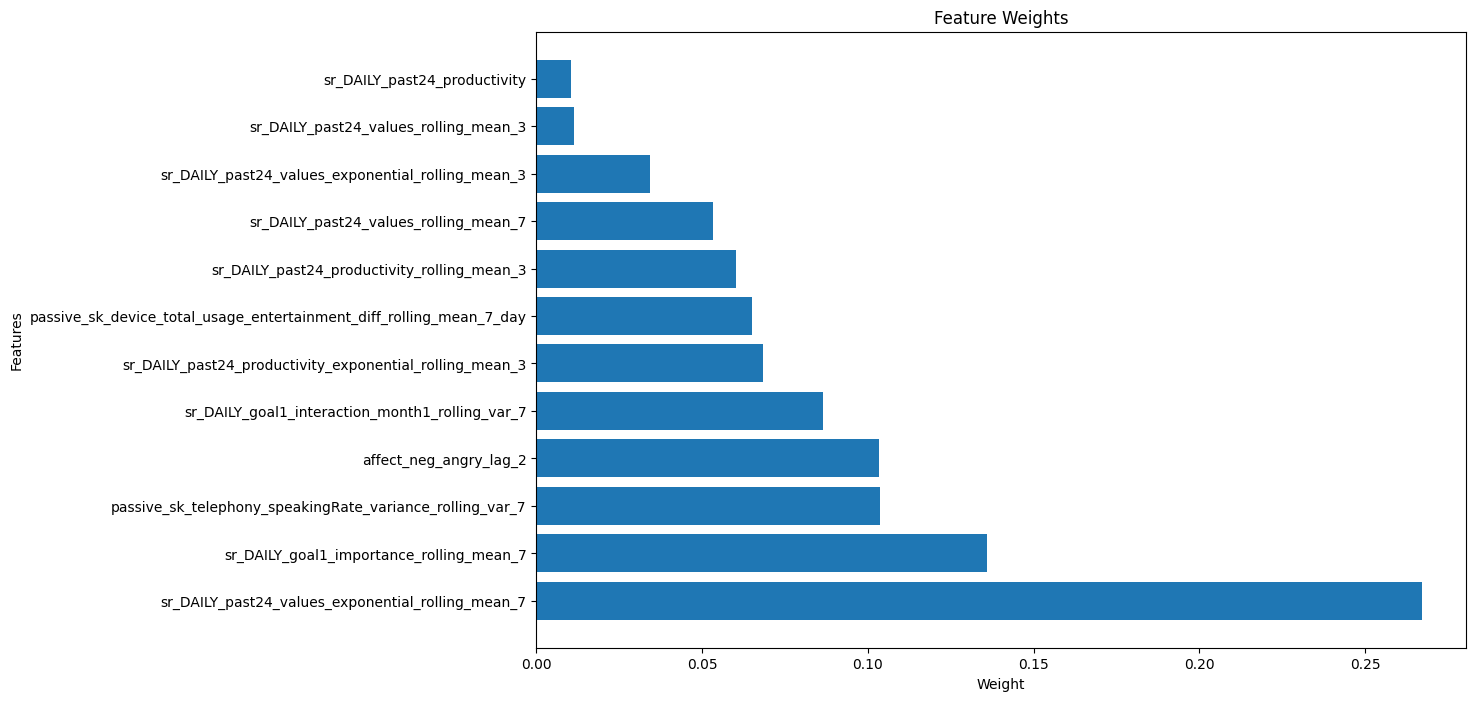

In [252]:
# Plotting
plt.figure(figsize=(12, 8))
plt.barh(list(feature_imps.keys()), list(feature_imps.values()))
plt.xlabel('Weight')
plt.ylabel('Features')
plt.title('Feature Weights')
plt.show()

In [ ]:
# Errors
# Sub 12
# Sub 46
# Sub 74
# Sub 97

In [253]:
results_df

,subject,logistic_reg,random_forest,xgboost,ensemble,p_val,ffill,feature_import_xgb
0,0,0.615385,0.630769,0.630769,0.584615,0.093730,0,{'sr_DAILY_goal2_motivationInternal_lag_2': 0....
1,1,0.400000,0.384615,0.446154,0.353846,0.997980,5,{'passive_sk_device_total_usage_health_and_fit...
2,2,0.476923,0.523077,0.584615,0.492308,0.671504,3,{'sr_DAILY_goal1_confidence_rolling_mean_7': 0...
3,3,0.600000,0.600000,0.600000,0.569231,0.136134,7,{'passive_sk_device_total_screen_wakes_exponen...
4,4,0.615385,0.615385,0.553846,0.553846,0.214104,0,"{'sr_DAILY_goal1_confidence': 0.22176681, 'pas..."
...,...,...,...,...,...,...,...,...
96,100,0.569231,0.600000,0.569231,0.584615,0.093730,9,{'task_nasa_luck_exponential_rolling_mean_7': ...
97,101,0.492308,0.476923,0.492308,0.461538,0.810000,11,{'affect_neg_stressed_exponential_rolling_mean...
98,102,0.600000,0.630769,0.600000,0.600000,0.061927,3,{'passive_sk_messages_inOut_ratio_exponential_...
99,103,0.446154,0.461538,0.523077,0.400000,0.976238,2,{'affect_neg_lazy_exponential_rolling_mean_7':...


In [255]:
results_df.describe()

,logistic_reg,random_forest,xgboost,ensemble,p_val
count,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.530725,0.548896,0.560473,0.518002,0.481558
std,0.074329,0.074912,0.070388,0.076394,0.347508
min,0.384615,0.353846,0.384615,0.353846,0.000030
25%,0.476923,0.492308,0.507692,0.461538,0.136134
50%,0.523077,0.538462,0.553846,0.507692,0.500000
75%,0.584615,0.600000,0.615385,0.569231,0.810000
max,0.769231,0.738462,0.707692,0.723077,0.997980


In [232]:
results_df_all_features

,subject,logistic_reg,random_forest,xgboost,ensemble,p_val,ffill
0,0,0.584615,0.600000,0.661538,0.661538,0.004018,0
1,1,0.507692,0.384615,0.446154,0.415385,0.960790,5
2,2,0.492308,0.523077,0.584615,0.523077,0.412157,3
3,3,0.538462,0.615385,0.461538,0.553846,0.255205,7
4,4,0.600000,0.584615,0.523077,0.507692,0.545027,0
...,...,...,...,...,...,...,...
96,100,0.461538,0.584615,0.476923,0.492308,0.669558,9
97,101,0.600000,0.507692,0.507692,0.492308,0.669558,11
98,102,0.553846,0.630769,0.600000,0.538462,0.330442,3
99,103,0.400000,0.553846,0.507692,0.430769,0.938073,2


In [146]:
results_df.describe()

,logistic_reg,random_forest,xgboost,ensemble,p_val
count,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.538083,0.558755,0.559004,0.524555,0.446220
std,0.066269,0.072820,0.065196,0.070420,0.326500
min,0.400000,0.384615,0.415385,0.353846,0.000011
25%,0.492308,0.507692,0.507692,0.476923,0.136134
50%,0.538462,0.553846,0.553846,0.523077,0.413202
75%,0.569231,0.600000,0.600000,0.569231,0.744795
max,0.769231,0.753846,0.707692,0.738462,0.997980


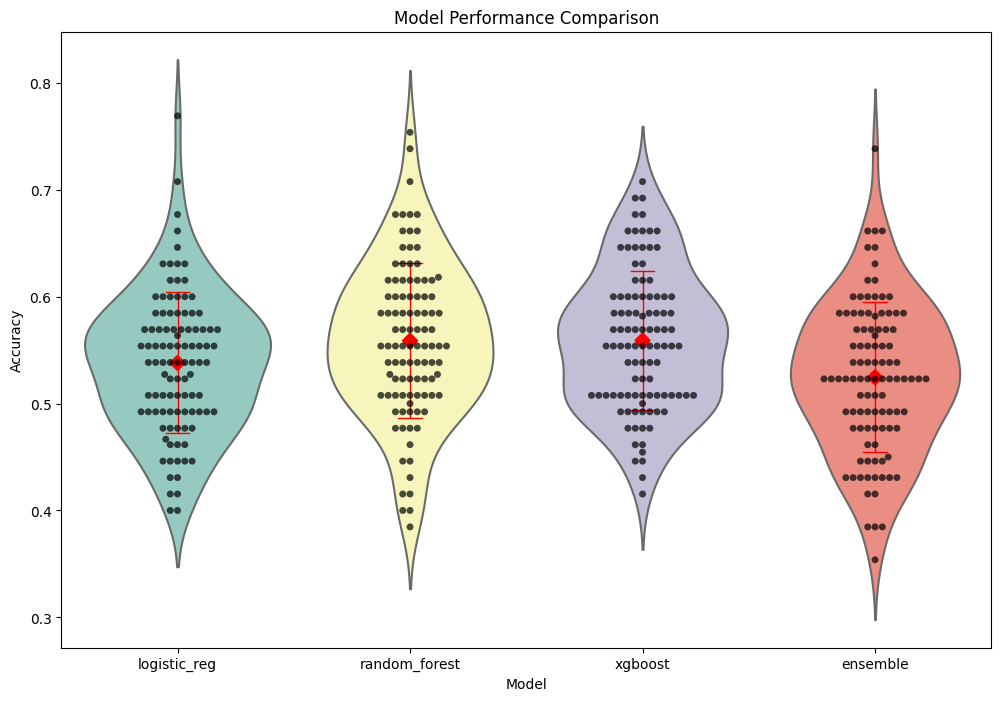

In [147]:
# Visualize
# Melt the dataframe for easier plotting with seaborn
melted_results_df = results_df.melt(id_vars=['subject'], value_vars=['logistic_reg', 'random_forest', 'xgboost', 'ensemble'],
                                    var_name='Model', value_name='Accuracy')

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Model', y='Accuracy', data=melted_results_df, inner=None, palette="Set3")

# Overlay actual data points
sns.swarmplot(x='Model', y='Accuracy', data=melted_results_df, color='k', alpha=0.7)

# Calculate means and standard errors
model_means = melted_results_df.groupby('Model')['Accuracy'].mean().reset_index()
model_errors = melted_results_df.groupby('Model')['Accuracy'].sem().reset_index()

# Overlay mean and error bars
sns.pointplot(x='Model', y='Accuracy', data=melted_results_df, join=False, capsize=0.1, 
              markers='D', errwidth=1, color='red', ci='sd')

# Add title and labels
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

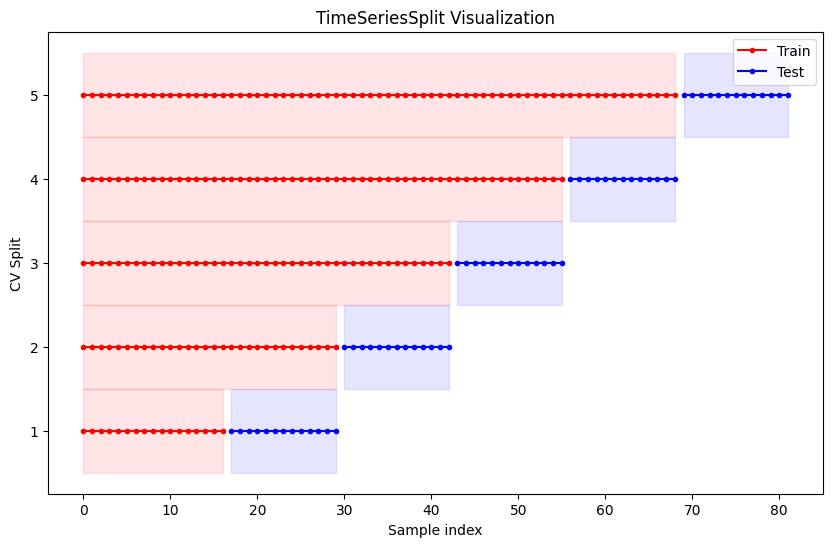

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Sample data
data = np.arange(1, 83)

# Initialize TimeSeriesSplit with 3 splits
tscv = TimeSeriesSplit(n_splits=5)

# Plotting the splits
plt.figure(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(data)):
    train_data, test_data = data[train_index], data[test_index]
    
    plt.plot(train_index, [i + 1] * len(train_index), 'r.-', label='Train' if i == 0 else "")
    plt.plot(test_index, [i + 1] * len(test_index), 'b.-', label='Test' if i == 0 else "")
    
    plt.fill_between(train_index, i + 0.5, i + 1.5, color='red', alpha=0.1)
    plt.fill_between(test_index, i + 0.5, i + 1.5, color='blue', alpha=0.1)

plt.yticks(range(1, tscv.n_splits + 1))
plt.xlabel('Sample index')
plt.ylabel('CV Split')
plt.title('TimeSeriesSplit Visualization')
plt.legend()
plt.show()


In [51]:
df_split.to_csv('df_split.csv', index=False)

### Target column

In [7]:
# Define a function to calculate the 3-day moving average with forward-looking window
def forward_moving_average(series, window=3):
    return series.rolling(window=window, min_periods=1).mean().shift(-window)

# Apply the moving average calculation for each PID
df_good['target'] = df_good.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average(x, window=3))

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import binom_test

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['subject', 'logistic_reg_cv', 'random_forest_cv', 'xgboost_cv', 'ensemble_cv', 'logistic_reg_test', 'random_forest_test', 'xgboost_test', 'ensemble_test', 'p_val_xgb_cv', 'ffill', 'xgb_predictions'])

# How many features to use
num_features = 15

for i in range(len(np.unique(df_good.PID))):
    print("Subject", i)
    
    try:
        df_split = subject_df(df=df_good, sub_num=i)

        # Use pd.qcut to create categories
        df_split['y_cat'], bins = pd.qcut(df_split['target'], q=2, labels=['Low', 'High'], retbins=True)

        # Make boolean
        df_split['y_cat_high'] = df_split['y_cat'].cat.codes
        df_split['y_cat_high'] = df_split['y_cat_high'].replace(-1, np.nan)

        # Target column is next day's gap
        df_split['y_cat_highNextDay'] = df_split['y_cat_high'].shift(-1)

        # Drop non-boolean cat
        df_split.drop(columns='y_cat', inplace=True)

        # Remove trailing rows since no y1 value
        df_split = df_split.iloc[:-2]

        # Separate features and target variable
        X = df_split.drop(columns=['y_cat_highNextDay'])
        y = df_split['y_cat_highNextDay']

        # Remove initial rows with NaN values for y_cat_high
        while y.isnull().iloc[0]:
            X = X.iloc[1:].reset_index(drop=True)
            y = y.iloc[1:].reset_index(drop=True)
        
        # Remove all "target" columns
        X = X.loc[:, ~X.columns.str.contains('target')]
        
        # Count missing values before imputation
        missing_values_before = y.isnull().sum()

        # Impute missing values in the target variable using forward fill
        y = y.fillna(method='ffill')

        # Count missing values after imputation
        missing_values_after = y.isnull().sum()

        # Calculate the number of imputed values
        imputed_value_count = missing_values_before - missing_values_after

        # Ensure there are no more NaN values in y
        if y.isnull().sum() == 0:
            # Train-test split for time series data
            split_ratio = 0.8
            split_index = int(len(X) * split_ratio)

            X_train, X_test = X[:split_index], X[split_index:]
            y_train, y_test = y[:split_index], y[split_index:]

            # Handle missing values and standardize features
            imputer = SimpleImputer(strategy='mean')
            scaler = StandardScaler()

            # Feature selection
            k_best = SelectKBest(score_func=f_classif, k=num_features)

            # Models
            log_reg = LogisticRegression(max_iter=1000)
            rf = RandomForestClassifier(n_estimators=100)
            xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')

            # TimeSeriesSplit
            tscv = TimeSeriesSplit(n_splits=5)

            # Pipelines
            log_reg_pipeline = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler),
                ('k_best', k_best),
                ('classifier', log_reg)
            ])

            rf_pipeline = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler),
                ('k_best', k_best),
                ('classifier', rf)
            ])

            xgb_pipeline = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler),
                ('k_best', k_best),
                ('classifier', xgb_clf)
            ])

            # Define the parameter grids for each model
            param_grid_log_reg = {
                'classifier__C': [0.01, 0.1, 1, 10, 100]
            }

            param_grid_rf = {
                'classifier__n_estimators': [50, 100, 200],
                'classifier__max_depth': [None, 10, 20, 30]
            }

            param_grid_xgb = {
                'classifier__n_estimators': [50, 100, 200],
                'classifier__learning_rate': [0.01, 0.1, 0.2],
                'classifier__max_depth': [3, 6, 9],
                'classifier__reg_alpha': [0, 0.1, 0.5],
                'classifier__reg_lambda': [0, 0.5, 1]
            }

            # Setup GridSearchCV for each model
            grid_log_reg = GridSearchCV(log_reg_pipeline, param_grid_log_reg, cv=tscv, scoring='accuracy')
            grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=tscv, scoring='accuracy')
            grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=tscv, scoring='accuracy')

            # Fit the models with cross-validation
            grid_log_reg.fit(X_train, y_train)
            grid_rf.fit(X_train, y_train)
            grid_xgb.fit(X_train, y_train)

            # Print best parameters for the XGBoost model
            print("Best parameters for XGBoost:", grid_xgb.best_params_)

            # Best estimators from cross-validation
            best_log_reg = grid_log_reg.best_estimator_
            best_rf = grid_rf.best_estimator_
            best_xgb = grid_xgb.best_estimator_

            # Ensemble with VotingClassifier
            voting_clf = VotingClassifier(estimators=[
                ('log_reg', best_log_reg),
                ('rf', best_rf),
                ('xgb', best_xgb)
            ], voting='soft')

            # Fit the ensemble model
            voting_clf.fit(X_train, y_train)

            # Cross-validation scores for ensemble model
            ensemble_cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=tscv, scoring='accuracy')

            # Predictions and accuracy on the held-out test set
            y_pred_log_reg = best_log_reg.predict(X_test)
            y_pred_rf = best_rf.predict(X_test)
            y_pred_xgb = best_xgb.predict(X_test)
            y_pred_ensemble = voting_clf.predict(X_test)

            log_reg_accuracy_test = accuracy_score(y_test, y_pred_log_reg)
            rf_accuracy_test = accuracy_score(y_test, y_pred_rf)
            xgb_accuracy_test = accuracy_score(y_test, y_pred_xgb)
            ensemble_accuracy_test = accuracy_score(y_test, y_pred_ensemble)

            # Cross-validation accuracies
            log_reg_accuracy_cv = grid_log_reg.best_score_
            rf_accuracy_cv = grid_rf.best_score_
            xgb_accuracy_cv = grid_xgb.best_score_
            ensemble_accuracy_cv = ensemble_cv_scores.mean()

            # Store predictions and actual values in a dictionary for XGBoost
            prediction_dict = [{'predicted_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred_xgb, y_test)]

            # Number of test samples
            n = len(y_test)
            # Number of correct predictions (assuming ensemble model predictions)
            k = int(xgb_accuracy_cv * n)
            p_chance = 0.5  # Chance level accuracy

            # Perform the binomial test
            p_value = binom_test(k, n, p_chance, alternative='greater')

            # Save results to the DataFrame using pd.concat
            new_row = pd.DataFrame({
                'subject': [i],
                'logistic_reg_cv': [log_reg_accuracy_cv],
                'random_forest_cv': [rf_accuracy_cv],
                'xgboost_cv': [xgb_accuracy_cv],
                'ensemble_cv': [ensemble_accuracy_cv],
                'logistic_reg_test': [log_reg_accuracy_test],
                'random_forest_test': [rf_accuracy_test],
                'xgboost_test': [xgb_accuracy_test],
                'ensemble_test': [ensemble_accuracy_test],
                'p_val_xgb_cv': [p_value],
                'ffill': [imputed_value_count],
                'xgb_predictions': [prediction_dict]
            })
            results_df = pd.concat([results_df, new_row], ignore_index=True)
            
        else:
            print(f"Skipping subject {i} because the target variable y still contains NaN values after imputation.")
            continue
    except KeyError as err:
        print(f'Error with subject {i}')


Subject 0
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 50, 'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 0}
Subject 1


KeyboardInterrupt: 

In [11]:
results_df

,subject,logistic_reg_cv,random_forest_cv,xgboost_cv,ensemble_cv,logistic_reg_test,random_forest_test,xgboost_test,ensemble_test,p_val_xgb_cv,ffill,xgb_predictions
0,0,0.545455,0.472727,0.454545,0.472727,0.411765,0.411765,0.411765,0.352941,0.833847,2,"[{'predicted_value': 1, 'actual_value': 0.0}, ..."


# Dimensionality Reduction

## Highest Biserial Values

mixed effects = what are the best predictors

In [12]:
# Check for target column
[col for col in df_good.columns if 'heuristic' in col]

# Add target of next three days gap average
df_avg3_target = df_good.copy()

In [13]:
# Define a function to calculate the 3-day moving average with forward-looking window
def forward_moving_average(series, window=3):
    return series.rolling(window=window, min_periods=1).mean().shift(-window)

# Apply the moving average calculation for each PID
df_avg3_target['target'] = df_avg3_target.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average(x, window=3))

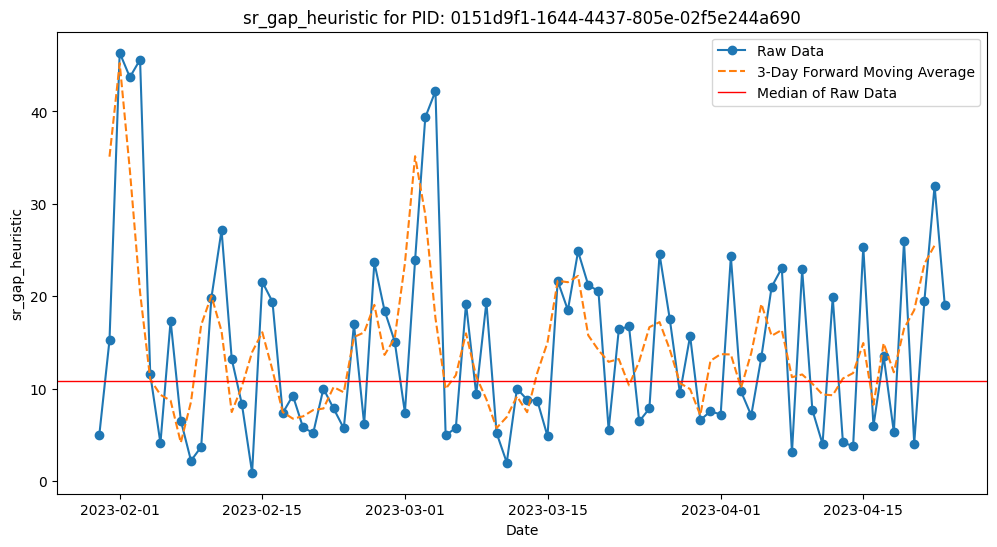

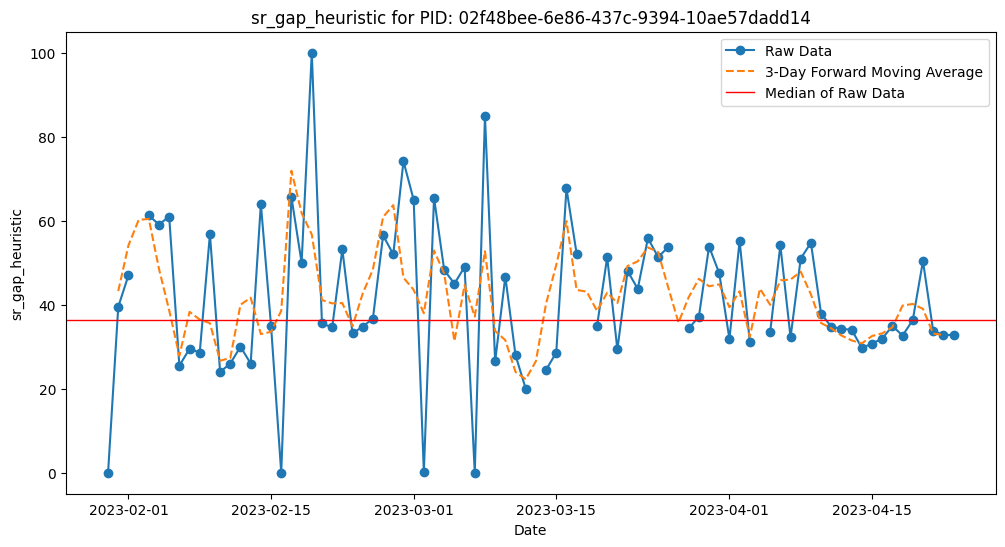

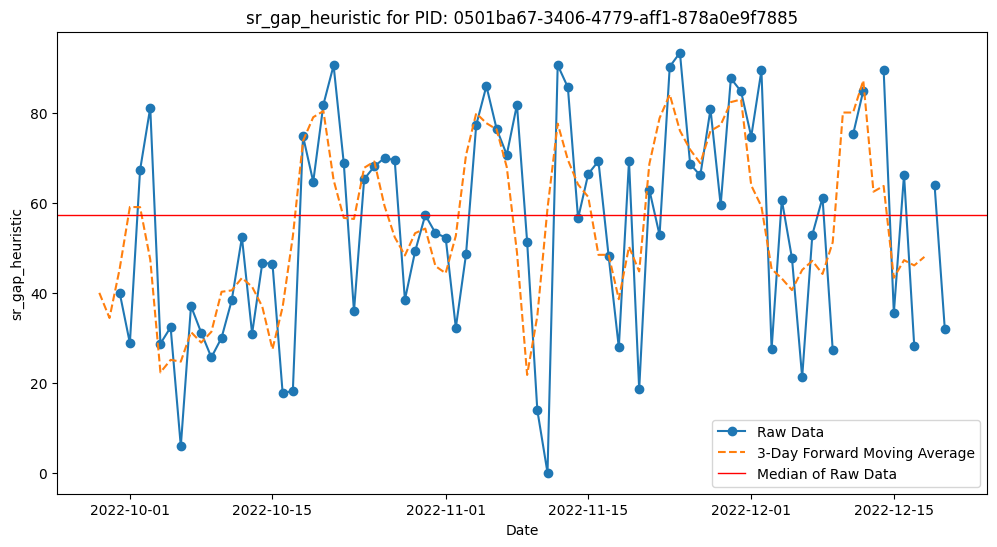

In [14]:
# Visualize a couple subjects with both original and three day smoothed gap

# This is not the same as the target as it is the average of [current day, cd+1, cd+2]
# The target column created is the average of [cd+1, cd+2, cd+3]

# Selecting two PIDs
pids = df_good['PID'].unique()[:3]

# Filter the dataframe for the two PIDs
df_filtered = df_good[df_good['PID'].isin(pids)][['PID', 'trial_date', 'sr_gap_heuristic']]

# Ensure the trial_date is in datetime format
df_filtered['trial_date'] = pd.to_datetime(df_filtered['trial_date'])

# Sort by trial_date for each PID
df_filtered = df_filtered.sort_values(by=['PID', 'trial_date'])

# Apply the moving average calculation for each PID
df_filtered['sr_gap_heuristic_moving_avg'] = df_filtered.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average(x, window=3))

# Plot the data for each PID
for pid in pids:
    df_pid = df_filtered[df_filtered['PID'] == pid]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_pid['trial_date'], df_pid['sr_gap_heuristic'], label='Raw Data', marker='o')
    plt.plot(df_pid['trial_date'], df_pid['sr_gap_heuristic_moving_avg'].shift(1), label='3-Day Forward Moving Average', linestyle='--')
    
    # Add a horizontal line at the median of the raw data
    median_value = df_pid['sr_gap_heuristic'].median()
    plt.axhline(median_value, color='red', linestyle='-', linewidth=1, label='Median of Raw Data')
    
    plt.title(f'sr_gap_heuristic for PID: {pid}')
    plt.xlabel('Date')
    plt.ylabel('sr_gap_heuristic')
    plt.legend()
    plt.show()

In [25]:
df_avg3_target.loc[df_avg3_target.PID==np.unique(df_avg3_target.PID)[0],'target']

0     35.100000
1     45.216667
2     33.616667
3     20.416667
4     11.000000
        ...    
80    23.500000
81    25.500000
82          NaN
83          NaN
84          NaN
Name: target, Length: 85, dtype: float64

In [31]:
import statsmodels.formula.api as smf
import pandas as pd

def fit_mixed_effects_model(df, target_col, predictor_col, group_col):
    # Drop rows with missing values in the required columns
    df = df.dropna(subset=[target_col, predictor_col, group_col])
    
    if df.empty:
        raise ValueError("DataFrame is empty after dropping NA values.")
    
    # Define the formula for the mixed-effects model
    formula = f"{target_col} ~ {predictor_col}"
    re_formula = f"~ {predictor_col}"

    # Fit the mixed-effects model with random intercept and random slope
    model = smf.mixedlm(formula, df, groups=df[group_col], re_formula=re_formula)
    result = model.fit(max_iter=1000)

    # Check for convergence
    if not result.converged:
        raise ValueError("Model did not converge.")
    
    return result

target_col = 'target'
group_col = 'PID'
feature_columns = [col for col in df_avg3_target.columns if col not in [target_col, group_col]]

mlm_results = pd.DataFrame(columns=["feature", "Coef.", "Std.Err", "z", "P>|z|", "[0.025", "0.975]"])

# Fit the model
try:
    result = fit_mixed_effects_model(df_avg3_target, 'target', 'affect_neg_depressed', 'PID')
    # print(result.summary())
    
except Exception as e:
    print(f"Model fitting failed: {e}")
    
for feature in tqdm(feature_columns):
    try:
        result = fit_mixed_effects_model(df_avg3_target, target_col, feature, group_col)
        # Save results to the DataFrame using pd.concat
        new_row = pd.DataFrame({
            'feature': [target_col],
            'Coef.': [result.params[1]],
            'Std.Err.': [result.bse[1]],
            'z': [result.tvalues[1]],
            'P>|z|': [result.pvalues[1]],
            '[0.025': [result.conf_int().iloc[1,0]],
            '0.975]': [result.conf_int().iloc[1,1]]
        })
        mlm_results = pd.concat([mlm_results, new_row], ignore_index=True)
    except Exception as e:
        print(f"Model failed for {feature}: {e}")


                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       target     
No. Observations:        7610          Method:                   REML       
No. Groups:              105           Scale:                    125.8685   
Min. group size:         40            Log-Likelihood:           -29433.6665
Max. group size:         82            Converged:                Yes        
Mean group size:         72.5                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         40.558    1.194 33.976 0.000 38.219 42.898
affect_neg_depressed               0.739    0.182  4.067 0.000  0.383  1.095
Group Var                        136.429    1.860                           
Group x affect_neg_

In [50]:
result.conf_int().iloc[1,0]
result.conf_int().iloc[1,1]
result.pvalues[1]
result.tvalues[1]
result.params[1] # Coef.
result.bse[1] # Std.Err.

Intercept                           1.193715
affect_neg_depressed                0.181664
Group Var                           0.165779
Group x affect_neg_depressed Cov    0.017678
affect_neg_depressed Var            0.003253
dtype: float64

In [30]:
import statsmodels.formula.api as smf
import pandas as pd
from tqdm import tqdm

def fit_mixed_effects_model(df, target_col, predictor_col, group_col):
    df = df.dropna(subset=[target_col, predictor_col, group_col])
    
    if df.empty:
        raise ValueError("DataFrame is empty after dropping NA values.")
    
    # Define the formula for the mixed-effects model with random intercept and random slope
    formula = f"{target_col} ~ {predictor_col}"
    re_formula = f"~ {predictor_col}"

    # Fit the mixed-effects model
    model = smf.mixedlm(formula, df, groups=df[group_col], re_formula=re_formula)
    result = model.fit(max_iter=1000)

    # Check for convergence
    if not result.converged:
        raise ValueError(f"Model did not converge for feature {predictor_col}.")
    
    return result

def get_model_results(result):
    # Extract the summary results into a dictionary
    summary = result.summary2().tables[1]
    summary = summary.rename(columns={"coef": "Coef.", "stderr": "Std.Err", "z": "z", "P>|z|": "P>|z|"})
    
    # Get the 95% confidence intervals
    summary["[0.25, 0.975]"] = result.conf_int().loc[:, 0.025].round(3).astype(str) + ", " + result.conf_int().loc[:, 0.975].round(3).astype(str)
    
    summary["[0.25, 0.975]"] = summary["[0.25, 0.975]"].apply(lambda x: f"[{x}]")
    
    return summary

target_col = 'target'
group_col = 'PID'
feature_columns = [col for col in df_avg3_target.columns if col not in [target_col, group_col]]

mlm_results = pd.DataFrame(columns=["feature", "Coef.", "Std.Err", "z", "P>|z|", "[0.25, 0.975]"])

for feature in tqdm(feature_columns):
    try:
        result = fit_mixed_effects_model(df_avg3_target, target_col, feature, group_col)
        summary = get_model_results(result)
        summary["feature"] = feature
        mlm_results = mlm_results.append(summary, ignore_index=True)
    except Exception as e:
        print(f"Model failed for {feature}: {e}")

# Display the results
print(mlm_results)


  0%|          | 0/537 [00:43<?, ?it/s]


KeyboardInterrupt: 

In [16]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Function to fit mixed effects model and get R2
def fit_mixed_effects_model(df, feature):
    df = df.dropna(subset=['target', feature, 'PID'])
    
    if df.empty or df[feature].nunique() < 2:
        raise ValueError(f"Not enough data for feature {feature}")
    
    # Scale the feature
    scaler = StandardScaler()
    df[feature] = scaler.fit_transform(df[[feature]])
    
    formula = f"target ~ {feature}"
    re_formula = f"~{feature}"
    model = smf.mixedlm(formula, df, groups=df["PID"], re_formula=re_formula)
    result = model.fit(max_iter=1000)
    
    # Check for convergence issues
    if not result.converged:
        raise ValueError(f"Model did not converge for feature {feature}")
    
    # Calculate R-squared for mixed-effects model
    overall_mean = df['target'].mean()
    ss_total = sum((df['target'] - overall_mean)**2)
    
    predictions = result.predict()
    ss_residual = sum((df['target'] - predictions)**2)
    r_squared = 1 - (ss_residual / ss_total)
    
    return result, r_squared

# Identify feature columns
feature_columns = [col for col in df_avg3_target.columns if col not in ['target', 'PID', 'trial_date']]

# Iterate over features, store results
results = []
for feature in tqdm(feature_columns):
    try:
        result, r_squared = fit_mixed_effects_model(df_avg3_target, feature)
        summary = {
            "feature": feature,
            "coef": result.fe_params[feature],
            "p_value": result.pvalues[feature],
            "aic": result.aic,
            "bic": result.bic,
            "log_likelihood": result.llf,
            "r_squared": r_squared
        }
        results.append(summary)
    except Exception as e:
        print(f"Model failed for {feature}: {e}")
        continue

mlm_features = pd.DataFrame(results)

# Display the results
print(mlm_features)


  0%|          | 0/536 [00:00<?, ?it/s]

  2%|▏         | 10/536 [00:14<12:55,  1.47s/it]


KeyboardInterrupt: 

In [20]:
mlm_features = pd.DataFrame(results)
mlm_features.sort_values(by='p_value')

,feature,coef,p_value,aic,bic,log_likelihood,r_squared
3,affect_neg_depressed,0.924372,0.000048,NaN,NaN,-29433.442318,0.026076
2,affect_neg_bored,0.979245,0.000229,NaN,NaN,-29407.418509,0.022039
1,affect_neg_ashamed,0.950299,0.000597,NaN,NaN,-29427.479243,0.026366
7,affect_neg_lazy,0.922674,0.000983,NaN,NaN,-29390.878342,0.025522
8,affect_neg_lonelyIsolated,0.808937,0.002503,NaN,NaN,-29422.866910,0.019600
4,affect_neg_embarrassed,0.710822,0.006020,NaN,NaN,-29424.144436,0.015602
0,affect_neg_angry,0.511454,0.037240,NaN,NaN,-29428.835513,0.012509
6,affect_neg_guilty,0.571311,0.037354,NaN,NaN,-29420.378871,0.013991
5,affect_neg_frustrated,0.457737,0.051000,NaN,NaN,-29434.942894,0.011752
9,affect_neg_nervousAnxious,-0.047955,0.861040,NaN,NaN,-29423.221634,-0.001436


## Recursive Feature Elimination

In [167]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_imputed, y)

print(f"Optimal number of features: {rfecv.n_features_}")

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown

Optimal number of features: 14


In [171]:
list(np.array(X.columns)[rfecv.support_])

['sr_DAILY_goal2_consequences',
 'passive_hk_hr_variability',
 'task_food_5_rating',
 'sr_DAILY_past24_procrastination_rolling_mean_3',
 'task_spatialSpan_score_rolling_mean_7',
 'passive_sk_device_total_usage_finance_rolling_mean_3',
 'affect_neg_guilty_lag_3',
 'affect_pos_happy_lag_2',
 'sr_DAILY_goal2_motivationExternal_lag_2',
 'task_nback_bid_lag_1',
 'passive_hk_sleep_REM_lag_3',
 'sr_DAILY_goal1_interaction_week2_lag_1',
 'task_food_9_rating_lag_3',
 'day_of_week_Saturday']

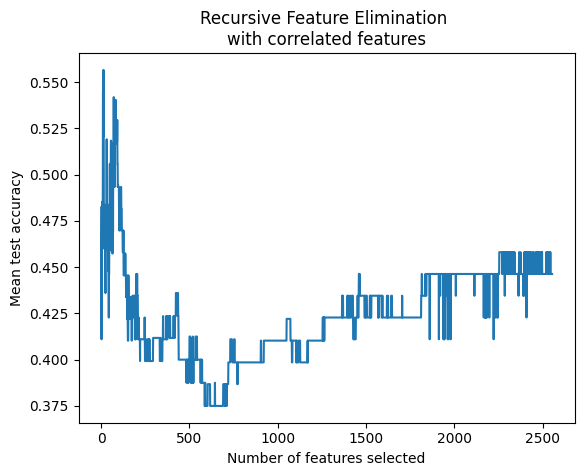

In [172]:
# plot RFE

cv_results = pd.DataFrame(rfecv.cv_results_)
n_features = np.arange(1, len(cv_results['mean_test_score']) + 1)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=n_features,
    y=cv_results["mean_test_score"]
    #yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## PCA

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Generate a sample time series dataset
np.random.seed(42)
n_samples = 1000
n_features = 10

X = np.random.randn(n_samples, n_features)
y = np.random.randint(0, 2, n_samples)

# Introduce missing values
X[::10, 0] = np.nan

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Define the model
model = LogisticRegression(max_iter=1000)

# Define the time series split strategy
tscv = TimeSeriesSplit(n_splits=5)

# Placeholder to store results
results = []

# Loop over different numbers of PCA components
for n_components in range(1, n_features + 1):
    # Apply PCA to get explained variance ratio
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(StandardScaler().fit_transform(X_imputed))
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)
    
    # Create a pipeline with PCA and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize the features
        ('pca', PCA(n_components=n_components)),  # Apply PCA
        ('classifier', model)  # Logistic regression classifier
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_imputed, y, cv=tscv, scoring='accuracy')
    
    # Store the mean score, the number of components, and the explained variance ratio
    results.append((n_components, scores.mean(), explained_variance_ratio))

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['n_components', 'mean_accuracy', 'explained_variance_ratio'])

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of PCA Components')
ax1.set_ylabel('Mean Accuracy', color=color)
ax1.plot(results_df['n_components'], results_df['mean_accuracy'], marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Explained Variance Ratio', color=color)  # we already handled the x-label with ax1
ax2.plot(results_df['n_components'], results_df['explained_variance_ratio'], marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Model Performance and Explained Variance vs. Number of PCA Components')
plt.grid(True)
plt.show()


## LDA

## Autoencoder

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the Random Forest model and the number of features to select
rfecv = RFECV(estimator=rf, n_features_to_select=10, step=1)  # Adjust 'n_features_to_select' as needed

# Fit RFE
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:", selected_features)

# Transform the training and testing datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the Random Forest model on the reduced set of features
rf.fit(X_train_rfe, y_train)

# Evaluate the model
accuracy = rf.score(X_test_rfe, y_test)
print("Model accuracy with selected features:", accuracy)

## Manual Column Selection

Select columns to keep and then look at the conjoint of the subjects columns (as they may differ) and the columns to keep.

In [ ]:
# specify columns to drop

'passive_sk_device_total_usage_books',
'passive_sk_device_total_usage_education',
'passive_sk_device_total_usage_food_and_drink',
'passive_sk_device_total_usage_miscellaneous',
'passive_sk_device_total_usage_navigation',
'passive_sk_device_total_usage_travel',
'passive_sk_device_total_usage_utilities',
'passive_sk_device_total_usage_weather',

'passive_sk_visits_home_elapsed',
'passive_sk_visits_unknown_elapsed',
'passive_sk_visits_work_elapsed',
'passive_sk_visits_unknown_count',
'passive_hk_hr_averageWalking',

'task_motivation_level',
'task_gng_incorrectNoGo',
'task_gng_incorrectGo',
'task_gng_avgRt',
'task_bart_avg_rt',
'task_bart_total_pumps',
'task_emoStroop_accuracy_incongruent',
'task_emoStroop_accuracy_congruent',
'task_emoStroop_rt_incongruent',
'task_emoStroop_rt_congruent',
'task_nback_rndNum',
'task_nback_matched',
'task_nback_missed',
'task_nback_falseAlarm',
'task_nback_accuracy',
'task_nasa_luck',
'task_nasa_performance',
'task_nasa_temporal _demand',
'task_trailmaking_alphaNumeric_errors',
'task_trailmaking_numeric_errors',
'task_trailmaking_alphaNumeric_time',
'task_trailmaking_numeric_time',
'task_trailmaking_alphaNumeric_var',
'task_trailmaking_numeric_var',
'task_stroop_totalCorrectProp',
'task_stroop_congruentCorrectProp',
'task_stroop_incongruentCorrectProp',
'task_stroop_totalAvgRT',
'task_stroop_congruentAvgRT',
'task_stroop_incongruentAvgRT',
'task_psat_accuracy',
'task_psat_avgRT',
'task_psat_varRT',
'task_hanoi_time',
'task_rt_avgRT',
'task_spatialSpan_score',
'task_food_1_rating',
'task_food_1_rt',
'task_food_10_rating',
'task_food_10_rt',
'task_food_11_rating',
'task_food_11_rt',
'task_food_12_rating',
'task_food_12_rt',
'task_food_13_rating',
'task_food_13_rt',
'task_food_14_rating',
'task_food_14_rt',
'task_food_15_rating',
'task_food_15_rt',
'task_food_2_rating',
'task_food_2_rt',
'task_food_3_rating',
'task_food_3_rt',
'task_food_4_rating',
'task_food_4_rt',
'task_food_5_rating',
'task_food_5_rt',
'task_food_6_rating',
'task_food_6_rt',
'task_food_7_rating',
'task_food_7_rt',
'task_food_8_rating',
'task_food_8_rt',
'task_food_9_rating',
'task_food_9_rt',
'task_food_hunger_level',
'task_food_rt_flag',
'task_hanoi_movesTime_model_predict',
'task_emoStroop_interference',

'sr_DAILY_goal1_motivationExternal',
'sr_DAILY_goal1_motivationInternal',
'sr_DAILY_goal2_interaction_eachOther',
'sr_DAILY_goal2_motivationExternal',
'sr_DAILY_goal2_motivationInternal',
'sr_DAILY_goal1_interaction_month1',
'sr_DAILY_goal1_interaction_month2',
'sr_DAILY_goal1_interaction_week1',
'sr_DAILY_goal1_interaction_week2',
'sr_DAILY_goal2_interaction_month1',
'sr_DAILY_goal2_interaction_month2',
'sr_DAILY_goal2_interaction_week1',
'sr_DAILY_goal2_interaction_week2',

'sr_DAILY_past24_change',
'sr_DAILY_past24_exercise',
'sr_DAILY_past24_fatigue',
'sr_DAILY_past24_ideal',
'sr_DAILY_past24_illness',
'sr_DAILY_past24_leisureNonSolo',
'sr_DAILY_past24_leisureSolo',
'sr_DAILY_past24_mentalEffort',
'sr_DAILY_past24_nonoccupation',
'sr_DAILY_past24_occupation',
'sr_DAILY_past24_physicalEffort',
'sr_DAILY_past24_procrastination',
'sr_DAILY_past24_productivity',
'sr_DAILY_past24_punctuality',
'sr_DAILY_past24_satisfaction',
'sr_DAILY_past24_sleep',
'sr_DAILY_past24_socialMedia',
'sr_DAILY_past24_unusualEvents',
'sr_DAILY_past24_gapCause_internal',

In [121]:
[col for col in df.columns if 'sr_DAILY_past24' in col]

['sr_DAILY_past24_change',
 'sr_DAILY_past24_exercise',
 'sr_DAILY_past24_fatigue',
 'sr_DAILY_past24_ideal',
 'sr_DAILY_past24_illness',
 'sr_DAILY_past24_leisureNonSolo',
 'sr_DAILY_past24_leisureNonSoloMental',
 'sr_DAILY_past24_leisureNonSoloPhysical',
 'sr_DAILY_past24_leisureSolo',
 'sr_DAILY_past24_leisureSoloMental',
 'sr_DAILY_past24_mentalEffort',
 'sr_DAILY_past24_nonoccupation',
 'sr_DAILY_past24_occupation',
 'sr_DAILY_past24_physicalEffort',
 'sr_DAILY_past24_procrastination',
 'sr_DAILY_past24_productivity',
 'sr_DAILY_past24_punctuality',
 'sr_DAILY_past24_satisfaction',
 'sr_DAILY_past24_sleep',
 'sr_DAILY_past24_socialMedia',
 'sr_DAILY_past24_unusualEvents',
 'sr_DAILY_past24_gapCause_internal',
 'sr_DAILY_past24_change_rolling_mean_3',
 'sr_DAILY_past24_change_exponential_rolling_mean_3',
 'sr_DAILY_past24_change_rolling_mean_7',
 'sr_DAILY_past24_change_exponential_rolling_mean_7',
 'sr_DAILY_past24_exercise_rolling_mean_3',
 'sr_DAILY_past24_exercise_exponential_r

In [ ]:
'sr_gap_entry',

'passive_sk_device_total_unlocks',
'passive_sk_device_total_screen_wakes',
'passive_sk_device_total_unlock_duration',

'passive_sk_device_total_usage_social_networking',
'passive_sk_device_total_usage_health_and_fitness',
'passive_sk_device_total_usage_photo_and_video',
'passive_sk_device_total_usage_news',
'passive_sk_device_total_usage_games',
'passive_sk_device_total_usage_entertainment',
'passive_sk_device_total_usage_music',
'passive_sk_device_total_usage_productivity',

'passive_sk_keyboard_sentiment_combined_absolutist',
'passive_sk_keyboard_sentiment_combined_anger',
'passive_sk_keyboard_sentiment_combined_anxiety',
'passive_sk_keyboard_sentiment_combined_death',
'passive_sk_keyboard_sentiment_combined_down',
'passive_sk_keyboard_sentiment_combined_health',
'passive_sk_keyboard_sentiment_combined_lowEnergy',
'passive_sk_keyboard_sentiment_combined_positive',
'passive_sk_keyboard_sentiment_combined_sad',

'passive_sk_keyboard_typing_speed',
'passive_sk_keyboard_total_words',
'passive_sk_keyboard_total_autocorrections',
'passive_sk_keyboard_total_emojis',
'passive_sk_keyboard_total_pauses',
'passive_sk_keyboard_total_typing_episodes',

'passive_sk_calls_incoming',
'passive_sk_calls_outgoing',
'passive_sk_calls_duration',

'passive_sk_messages_incoming',
'passive_sk_messages_outgoing',
'passive_sk_messages_uniqueContacts',
'passive_sk_messages_inOut_ratio',

'passive_hk_hr_variability',
'passive_hk_hr_resting',

'css',

'affect_neg_angry',
'affect_neg_ashamed',
'affect_neg_bored',
'affect_neg_depressed',
'affect_neg_embarrassed',
'affect_neg_frustrated',
'affect_neg_guilty',
'affect_neg_lazy',
'affect_neg_lonelyIsolated',
'affect_neg_nervousAnxious',
'affect_neg_sad',
'affect_neg_stressed',
'affect_pos_amused',
'affect_pos_appreciated',
'affect_pos_excited',
'affect_pos_focused',
'affect_pos_happy',
'affect_pos_hopeful',
'affect_pos_motivated',
'affect_pos_relaxedCalm',

'task_motivation_level'

In [ ]:
# Define the columns to be used in the EFA
columns = [
    'affect_neg_angry', 'affect_neg_ashamed', 'affect_neg_bored', 
    'affect_neg_depressed', 'affect_neg_embarrassed', 'affect_neg_frustrated', 
    'affect_neg_guilty', 'affect_neg_lazy', 'affect_neg_lonelyIsolated', 
    'affect_neg_nervousAnxious', 'affect_neg_sad', 'affect_neg_stressed', 
    'affect_pos_amused', 'affect_pos_appreciated', 'affect_pos_excited', 
    'affect_pos_focused', 'affect_pos_happy', 'affect_pos_hopeful', 
    'affect_pos_motivated', 'affect_pos_relaxedCalm'
]

# Extract only the specified columns
efa_data = df[columns]

# Dropping missing values rows
efa_data.dropna(inplace=True)

# EFA: Affect

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(efa_data)
chi_square_value, p_value

(635.8293665800574, 1.8350643784805365e-49)

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(efa_data)
kmo_model

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.7517953038086188

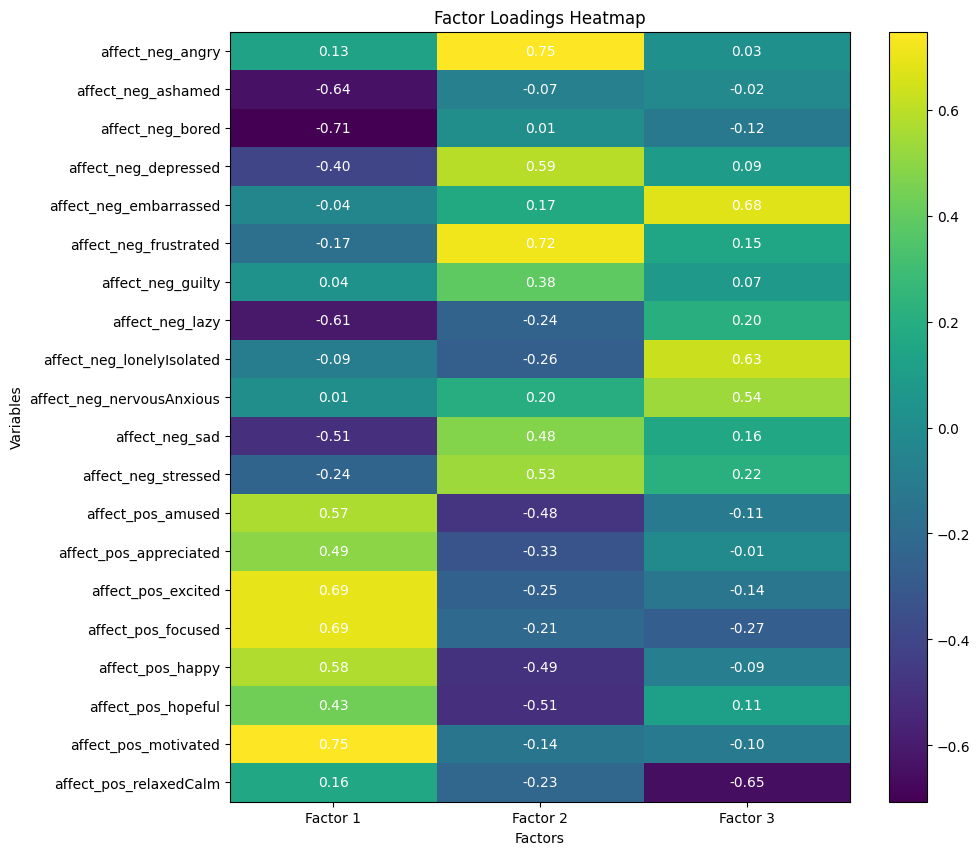

In [107]:
from factor_analyzer import FactorAnalyzer

n_factors = 3

# Perform EFA: Define the FactorAnalyzer object
fa = FactorAnalyzer(rotation='varimax', method='principal', n_factors=n_factors)
fa.fit(efa_data)

# Get the factor loadings and eigenvalues (for deciding the number of factors)
factor_loadings = fa.loadings_
eigen_values, _ = fa.get_eigenvalues()

factor_loadings, eigen_values

# Visualize factor loadings using a heatmap
plt.figure(figsize=(10, 10))
plt.title('Factor Loadings Heatmap')

# Create the heatmap
heatmap = plt.imshow(factor_loadings, cmap='viridis', aspect='auto')
plt.colorbar(heatmap)

# Set labels for columns (Factors)
factor_labels = []
for factor in range(n_factors):
     factor_labels.append('Factor ' + str(factor+1))
plt.xlabel('Factors')
plt.xticks(np.arange(len(factor_labels)), factor_labels)

# Set labels for rows (Variables)
plt.ylabel('Variables')
plt.yticks(np.arange(len(columns)), columns, rotation=0, fontsize=10)

# Annotate each cell with the numeric value
for i in range(len(columns)):
    for j in range(len(factor_labels)):
        plt.text(j, i, f'{factor_loadings[i, j]:.2f}', ha='center', va='center', color='white')

# Display the plot
plt.show()

In [106]:
fa.get_factor_variance()

(array([6.05364718]), array([0.30268236]), array([0.30268236]))

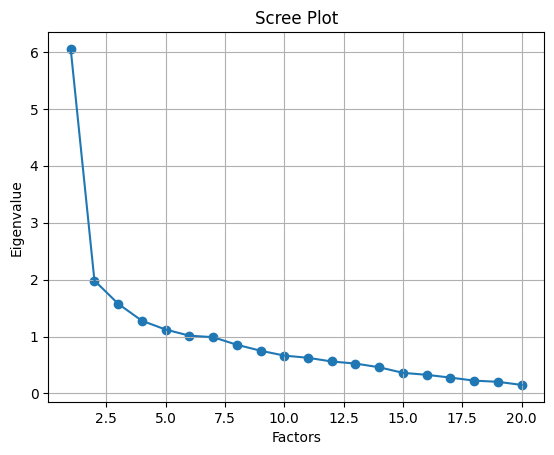

In [92]:
# Create scree plot using matplotlib
plt.scatter(range(1,efa_data.shape[1]+1),eigen_values)
plt.plot(range(1,efa_data.shape[1]+1),eigen_values)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

## PCA: Affect

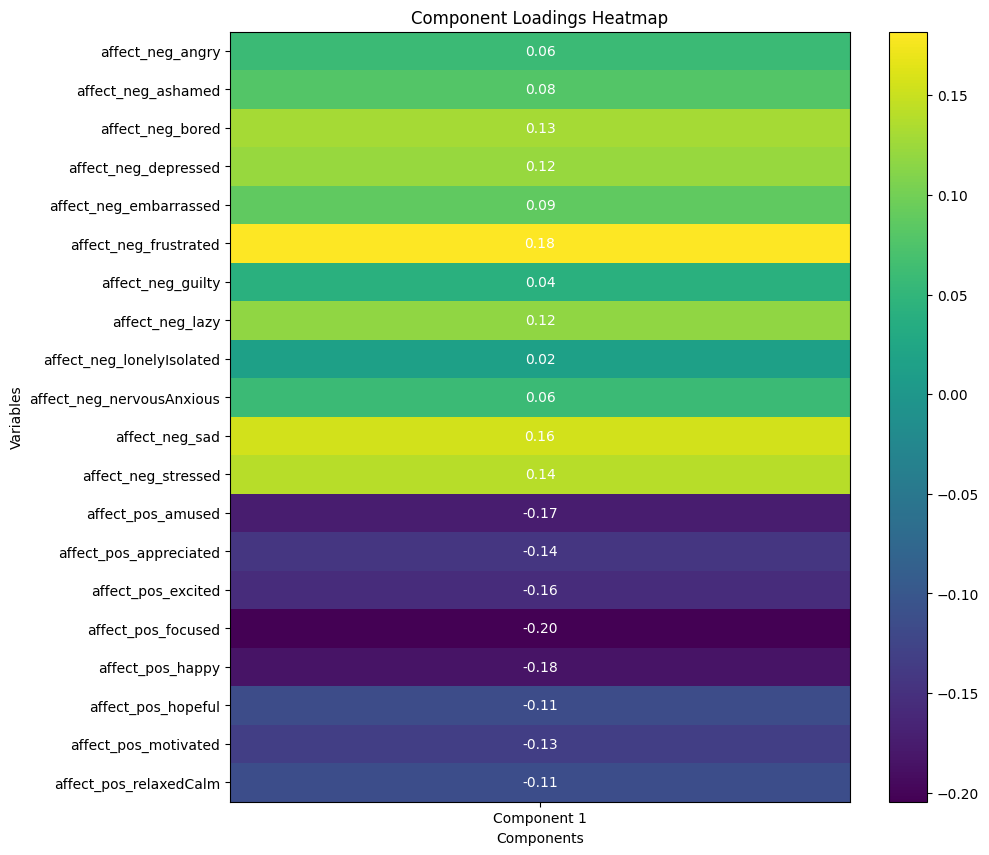

array([0.31032141])

In [104]:
from sklearn.decomposition import PCA

n_components = 1

# Initialize and fit PCA
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(efa_data)

# Calculate the variance explained by each of the components
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate loadings for the PCA components
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

explained_variance_ratio, loadings

# Visualize factor loadings using a heatmap
plt.figure(figsize=(10, 10))
plt.title('Component Loadings Heatmap')

# Create the heatmap
heatmap = plt.imshow(loadings, cmap='viridis', aspect='auto')
plt.colorbar(heatmap)

# Set labels for columns (Factors)
component_labels = []
for component in range(n_components):
     component_labels.append('Component ' + str(component+1))
plt.xlabel('Components')
plt.xticks(np.arange(len(component_labels)), component_labels)

# Set labels for rows (Variables)
plt.ylabel('Variables')
plt.yticks(np.arange(len(columns)), columns, rotation=0, fontsize=10)

# Annotate each cell with the numeric value
for i in range(len(columns)):
    for j in range(len(component_labels)):
        plt.text(j, i, f'{loadings[i, j]:.2f}', ha='center', va='center', color='white')

# Display the plot
plt.show()

explained_variance_ratio

# Gap Change

- Small increase
- Small decrease
- **Large increase**
- Large decrease

How well can we identify **THIS** category

# Smoothed Data